В этом ноутбуке приведен валидационный эксперимент, в рамках которого происходит обучение рекомендательной системы с помощью симулятора на искусственно сгенерированных данных.

Профили пользователей генерируются из распределения N(1,1); половина предложений генерируется из распределения N(-1, 1), другая половина -- из распределения N(1, 1). Отклики формируются как скалярное произведение профиля пользователя и профиля предложения, бинаризованное по порогу 0.5.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import random

import pandas as pd
import numpy as np

from pyspark.sql import SparkSession

from replay.session_handler import State

from simulator.utils import pandas_to_spark

SPARK_LOCAL_DIR = './tmp'
CHECKPOINT_DIR = '/data/home/estavinova/tmp/checkpoints'

spark = SparkSession.builder\
    .appName('simulator_validation')\
    .master('local[4]')\
    .config('spark.sql.shuffle.partitions', '4')\
    .config('spark.default.parallelism', '4')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '32g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

users_df = pd.DataFrame(data=np.random.normal(1, 1, size=(10000, 35)), columns=[f'user_attr_{i}' for i in range(35)]) 
items_df = pd.DataFrame(data=np.random.normal(-1, 1, size=(2000, 35)), columns=[f'item_attr_{i}' for i in range(35)]) 
items_df.loc[random.sample(range(2000), 1000)] = np.random.normal(1, 1, size=(1000, 35))
users_df['user_id'] = np.arange(len(users_df))
items_df['item_id'] = np.arange(len(items_df))
history_df_all = pd.DataFrame()
history_df_all['user_id'] = np.random.randint(0, 10000, size=33000)
history_df_all['item_id'] = np.random.randint(0, 2000, size=33000)
history_df_all['relevance'] = 0

users_matrix = users_df.values[history_df_all.values[:, 0], :-1]
items_matrix = items_df.values[history_df_all.values[:, 1], :-1]
dot = np.sum(users_matrix * items_matrix, axis=1)
history_df_all['relevance'] = np.where(dot >= 0.5, 1, 0)
history_df_all['timestamp'] = 0
history_df_all = history_df_all.drop_duplicates(subset=['user_id', 'item_id'], ignore_index=True)

history_df_train = history_df_all.iloc[:30000]
history_df_val = history_df_all.iloc[30000:]

users_df = pandas_to_spark(users_df)
items_df = pandas_to_spark(items_df)
history_df_train = pandas_to_spark(history_df_train)
history_df_val = pandas_to_spark(history_df_val)

22/11/10 12:27:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/10 12:27:37 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/11/10 12:27:38 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/10 12:27:38 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


### Syn data quality

На искусственно сгенерированных профилях пользователей обучается модель GaussianCopula для генерации синтетических профилей.

In [2]:
from simulator.modules import SDVDataGenerator, RealDataGenerator
from simulator.modules import evaluate_synthetic
import time

user_generator = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    seed=1234
)

item_generator = RealDataGenerator(
    label='real',
    seed=1234
)

start = time.time()
user_generator.fit(users_df.drop('user_id'))
end = time.time()
print(f'Fitting of users generator: {end - start}')

item_generator.fit(items_df)

syn_users = user_generator.generate(10000)
gen_score = evaluate_synthetic(syn_users.drop('user_id'), users_df.drop('user_id'))
print(gen_score)

22/11/10 12:28:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Fitting of users generator: 5.110503196716309


{'LogisticDetection': 1.0, 'SVCDetection': 0.925038533099306, 'KSTest': 0.9892714285714285, 'ContinuousKLDivergence': 0.9843989737554713}


### Response function quality

Синтетическая функция отклика представляет собой случайную величину из распределения Бернулли, вероятность успеха которого определяется косинусным расстоянием между профилями пользователя и предложения.

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import PipelineModel
from simulator.response import CosineSimilatiry, BernoulliResponse


va_users = VectorAssembler(
    inputCols=users_df.columns[:-1],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=items_df.columns[:-1],
    outputCol='features_itm'
)

cos_sim = CosineSimilatiry(
    inputCols=["features_usr", "features_itm"],
    outputCol="proba"
)

br = BernoulliResponse(inputCol='proba', outputCol='response')

cos_sim_model = PipelineModel(
    stages=[
        va_users,
        va_items,
        cos_sim,
        br
    ]
)

In [4]:
import pyspark.sql.functions as sf

train_df = history_df_train.join(users_df, 'user_id', 'left')\
                           .join(items_df, 'item_id', 'left')\
                           .drop('timestamp')

cos_df = cos_sim_model.transform(train_df)\
                      .select("user_id", "item_id", "relevance", "proba", "response")\
                      .withColumn('relevance', sf.col('relevance').cast('double'))\
                      .withColumn('response', sf.col('response').cast('double'))

cos_pdf = cos_df.toPandas()
cos_pdf[["relevance", "response"]].head(7)

,relevance,response
0,1.0,1.0
1,1.0,1.0
2,1.0,0.0
3,1.0,1.0
4,1.0,0.0
5,1.0,1.0
6,1.0,0.0


In [5]:
cos_pdf[["relevance", "response"]].describe()

,relevance,response
count,30000.000000,30000.000000
mean,0.501867,0.499967
std,0.500005,0.500008
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


<AxesSubplot: >

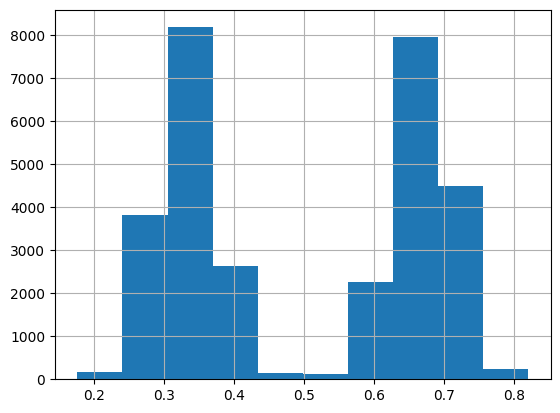

In [6]:
cos_pdf['proba'].hist()

<AxesSubplot: >

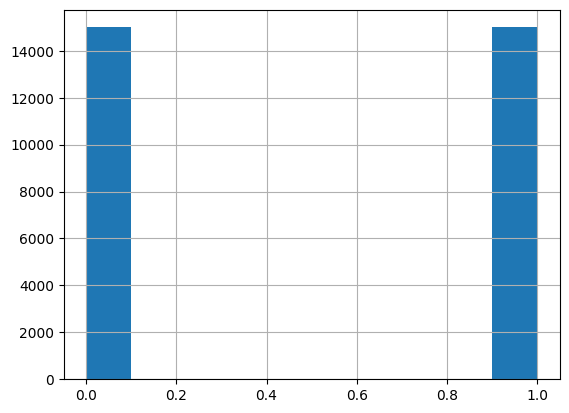

In [7]:
cos_pdf['response'].hist()

In [8]:
from simulator.modules import EvaluateMetrics

prob_eval = EvaluateMetrics(
    userKeyCol='user_id', itemKeyCol='item_id',
    predictionCol='proba', labelCol='relevance',
    mllib_metrics='areaUnderROC'
)

resp_eval = EvaluateMetrics(
    userKeyCol='user_id', itemKeyCol='item_id',
    predictionCol='response', labelCol='relevance',
    mllib_metrics=['weightedPrecision', 'weightedRecall']
)

print(prob_eval(cos_df), resp_eval(cos_df))

{'areaUnderROC': 0.9999997688856677} {'weightedPrecision': 0.6665738021969205, 'weightedRecall': 0.6665666666666666}


### RecSys training

Рекомендательная система обучается с помощью взаимодействия с симулятором в цикле. Качество рекомендательной системы оценивается с помощью метрик NDCG@10 и Precision@10.

In [9]:
from simulator.modules import Simulator

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=f'{CHECKPOINT_DIR}/validation',
)

from simulator.modules import EvaluateMetrics
from replay.metrics import NDCG, Precision, RocAuc

evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

In [10]:
from replay.data_preparator import Indexer

indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=user_generator.sample(0.01).unionByName(users_df), items=items_df)

from ucb import UCB
from replay.models import RandomRec

ucb = UCB(sample=True)
ucb.fit(log=indexer.transform(history_df_train.drop('response').limit(1)))

random_uni = RandomRec(distribution="uniform")
random_uni.fit(log=indexer.transform(history_df_train.drop('response')))

In [11]:
from operator import index
import pyspark.sql.types as st

LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)

items_replay = indexer.transform(items_df).cache()

ucb_metrics = []
random_metrics = []

for i in range(50):
    iter_start = time.time()

    users = sim.sample_users(0.02).cache()
    
    log = sim.get_log(users)
    if log is None:
        log = empty_log
    log = log.cache()

    recs_ucb = ucb.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=items_replay,
        filter_seen_items = False
    )
    recs_ucb = indexer.inverse_transform(recs_ucb).cache()

    recs_random = random_uni.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=items_replay,
        filter_seen_items = False
    )
    recs_random = indexer.inverse_transform(recs_random).cache()

    resp_ucb = sim.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items_df,
        action_models=cos_sim_model
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    resp_random = sim.sample_responses(
        recs_df=recs_random,
        user_features=users,
        item_features=items_df,
        action_models=cos_sim_model
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    sim.update_log(resp_ucb, iteration=i)

    ucb_metrics.append(evaluator(resp_ucb))
    random_metrics.append(evaluator(resp_random))

    ucb._clear_cache()
    ucb_train_log = sim.log.cache()
    ucb.fit(
        log=indexer.transform(
            ucb_train_log\
                .select('user_id', 'item_id', 'response')\
                .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    recs_random.unpersist()
    resp_ucb.unpersist()
    resp_random.unpersist()
    ucb_train_log.unpersist()

    print(f'Iteration {i} finished with time {time.time() - iter_start} sec.')

items_replay.unpersist()

Iteration 0 finished with time 26.462904453277588 sec.


Iteration 1 finished with time 20.171639442443848 sec.


Iteration 2 finished with time 19.744935750961304 sec.


Iteration 3 finished with time 19.00027561187744 sec.


Iteration 4 finished with time 18.42926049232483 sec.


Iteration 5 finished with time 18.510125637054443 sec.


Iteration 6 finished with time 19.945218563079834 sec.


Iteration 7 finished with time 18.58321762084961 sec.


Iteration 8 finished with time 18.815234184265137 sec.


Iteration 9 finished with time 19.674676656723022 sec.


Iteration 10 finished with time 20.404094219207764 sec.


Iteration 11 finished with time 18.29623579978943 sec.
Iteration 12 finished with time 19.717498064041138 sec.


Iteration 13 finished with time 19.423592805862427 sec.
Iteration 14 finished with time 19.836686849594116 sec.


Iteration 15 finished with time 21.0124614238739 sec.


Iteration 16 finished with time 24.49916911125183 sec.


Iteration 17 finished with time 21.81140375137329 sec.


22/11/10 12:43:42 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB


Iteration 18 finished with time 20.23279857635498 sec.


22/11/10 12:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB


Iteration 19 finished with time 20.62009596824646 sec.


22/11/10 12:44:24 WARN DAGScheduler: Broadcasting large task binary with size 1010.2 KiB


Iteration 20 finished with time 23.068140268325806 sec.


22/11/10 12:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1013.3 KiB


Iteration 21 finished with time 21.041341543197632 sec.


22/11/10 12:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB


Iteration 22 finished with time 22.477156162261963 sec.


22/11/10 12:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1020.5 KiB


Iteration 23 finished with time 22.329046487808228 sec.


22/11/10 12:45:52 WARN DAGScheduler: Broadcasting large task binary with size 1024.0 KiB


Iteration 24 finished with time 21.76172423362732 sec.


22/11/10 12:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1027.3 KiB


Iteration 25 finished with time 26.302621841430664 sec.


22/11/10 12:46:42 WARN DAGScheduler: Broadcasting large task binary with size 1030.3 KiB


Iteration 26 finished with time 26.068089962005615 sec.


22/11/10 12:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


Iteration 27 finished with time 27.74761939048767 sec.


22/11/10 12:47:37 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB


Iteration 28 finished with time 27.85243272781372 sec.


22/11/10 12:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1040.4 KiB


Iteration 29 finished with time 26.252649307250977 sec.


22/11/10 12:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1043.8 KiB


Iteration 30 finished with time 24.413100481033325 sec.


22/11/10 12:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1046.8 KiB


Iteration 31 finished with time 26.34947419166565 sec.


22/11/10 12:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1049.5 KiB
22/11/10 12:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB
22/11/10 12:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB
22/11/10 12:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1000.7 KiB


Iteration 32 finished with time 25.110827922821045 sec.


22/11/10 12:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
22/11/10 12:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
22/11/10 12:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
22/11/10 12:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB


Iteration 33 finished with time 24.793837070465088 sec.


22/11/10 12:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1055.2 KiB
22/11/10 12:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
22/11/10 12:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
22/11/10 12:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB


Iteration 34 finished with time 27.259754180908203 sec.


22/11/10 12:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1057.8 KiB
22/11/10 12:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/11/10 12:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/11/10 12:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB


Iteration 35 finished with time 25.160664558410645 sec.


22/11/10 12:51:04 WARN DAGScheduler: Broadcasting large task binary with size 1060.6 KiB
22/11/10 12:51:12 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
22/11/10 12:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
22/11/10 12:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB


Iteration 36 finished with time 27.19590735435486 sec.


22/11/10 12:51:31 WARN DAGScheduler: Broadcasting large task binary with size 1063.2 KiB
22/11/10 12:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
22/11/10 12:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
22/11/10 12:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB


Iteration 37 finished with time 28.509807586669922 sec.


22/11/10 12:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1065.7 KiB
22/11/10 12:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
22/11/10 12:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
22/11/10 12:52:10 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB


Iteration 38 finished with time 28.73331642150879 sec.


22/11/10 12:52:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.5 KiB
22/11/10 12:52:37 WARN DAGScheduler: Broadcasting large task binary with size 1019.7 KiB
22/11/10 12:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1019.7 KiB
22/11/10 12:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1019.7 KiB


Iteration 39 finished with time 28.395448207855225 sec.


22/11/10 12:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.1 KiB
22/11/10 12:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB
22/11/10 12:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB
22/11/10 12:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1022.3 KiB


Iteration 40 finished with time 28.72240686416626 sec.


22/11/10 12:53:25 WARN DAGScheduler: Broadcasting large task binary with size 1073.7 KiB
22/11/10 12:53:35 WARN DAGScheduler: Broadcasting large task binary with size 1025.0 KiB
22/11/10 12:53:35 WARN DAGScheduler: Broadcasting large task binary with size 1025.0 KiB
22/11/10 12:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1025.0 KiB


Iteration 41 finished with time 28.435955286026 sec.


22/11/10 12:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1075.8 KiB
22/11/10 12:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
22/11/10 12:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1027.0 KiB
22/11/10 12:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1027.0 KiB
22/11/10 12:54:05 WARN DAGScheduler: Broadcasting large task binary with size 1027.0 KiB


Iteration 42 finished with time 29.134895086288452 sec.


22/11/10 12:54:23 WARN DAGScheduler: Broadcasting large task binary with size 1078.3 KiB
22/11/10 12:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
22/11/10 12:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB
22/11/10 12:54:34 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB
22/11/10 12:54:34 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB


Iteration 43 finished with time 29.05633568763733 sec.


22/11/10 12:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1081.1 KiB
22/11/10 12:55:01 WARN DAGScheduler: Broadcasting large task binary with size 1006.6 KiB
22/11/10 12:55:01 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB
22/11/10 12:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB
22/11/10 12:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB


Iteration 44 finished with time 28.680014610290527 sec.


22/11/10 12:55:21 WARN DAGScheduler: Broadcasting large task binary with size 1083.6 KiB
22/11/10 12:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
22/11/10 12:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
22/11/10 12:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1009.1 KiB
22/11/10 12:55:31 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB
22/11/10 12:55:31 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB
22/11/10 12:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB


Iteration 45 finished with time 29.089479684829712 sec.


22/11/10 12:55:51 WARN DAGScheduler: Broadcasting large task binary with size 1086.2 KiB
22/11/10 12:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1003.6 KiB
22/11/10 12:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
22/11/10 12:56:00 WARN DAGScheduler: Broadcasting large task binary with size 1011.7 KiB
22/11/10 12:56:00 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB
22/11/10 12:56:01 WARN DAGScheduler: Broadcasting large task binary with size 1037.5 KiB
22/11/10 12:56:01 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB


Iteration 46 finished with time 30.082010984420776 sec.


22/11/10 12:56:20 WARN DAGScheduler: Broadcasting large task binary with size 1088.3 KiB
22/11/10 12:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
22/11/10 12:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
22/11/10 12:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
22/11/10 12:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
22/11/10 12:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
22/11/10 12:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB


Iteration 47 finished with time 29.418415069580078 sec.


22/11/10 12:56:47 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB
22/11/10 12:56:51 WARN DAGScheduler: Broadcasting large task binary with size 1007.7 KiB
22/11/10 12:56:51 WARN DAGScheduler: Broadcasting large task binary with size 1007.4 KiB
22/11/10 12:56:52 WARN DAGScheduler: Broadcasting large task binary with size 1015.5 KiB
22/11/10 12:56:52 WARN DAGScheduler: Broadcasting large task binary with size 1041.2 KiB
22/11/10 12:56:52 WARN DAGScheduler: Broadcasting large task binary with size 1041.2 KiB
22/11/10 12:56:52 WARN DAGScheduler: Broadcasting large task binary with size 1041.2 KiB


Iteration 48 finished with time 20.773516416549683 sec.


22/11/10 12:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1092.3 KiB
22/11/10 12:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1009.7 KiB
22/11/10 12:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1010.1 KiB
22/11/10 12:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1017.8 KiB
22/11/10 12:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1043.5 KiB
22/11/10 12:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1043.5 KiB
22/11/10 12:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1043.5 KiB


Iteration 49 finished with time 22.39671540260315 sec.


DataFrame[item_attr_0: double, item_attr_1: double, item_attr_2: double, item_attr_3: double, item_attr_4: double, item_attr_5: double, item_attr_6: double, item_attr_7: double, item_attr_8: double, item_attr_9: double, item_attr_10: double, item_attr_11: double, item_attr_12: double, item_attr_13: double, item_attr_14: double, item_attr_15: double, item_attr_16: double, item_attr_17: double, item_attr_18: double, item_attr_19: double, item_attr_20: double, item_attr_21: double, item_attr_22: double, item_attr_23: double, item_attr_24: double, item_attr_25: double, item_attr_26: double, item_attr_27: double, item_attr_28: double, item_attr_29: double, item_attr_30: double, item_attr_31: double, item_attr_32: double, item_attr_33: double, item_attr_34: double, item_idx: int]

(0.6, 1.01)

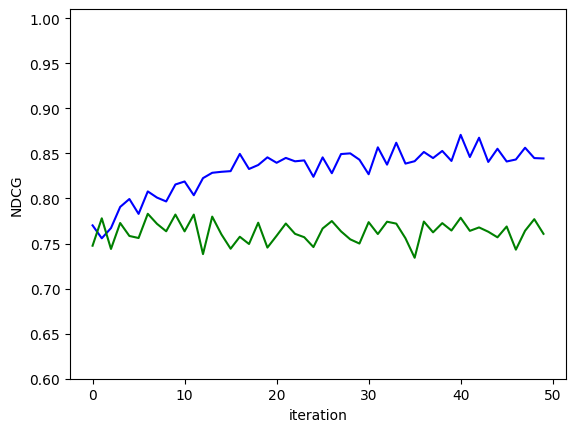

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

metrics_pdf = pd.DataFrame(ucb_metrics)
baseline_metrics_pdf = pd.DataFrame(random_metrics)
plt.plot(metrics_pdf['NDCG@10'], color='b')
plt.plot(baseline_metrics_pdf['NDCG@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.ylim(0.6, 1.01)
#plt.savefig('ndcg_mixed_sample.png', dpi=300) 

(0.3, 0.7)

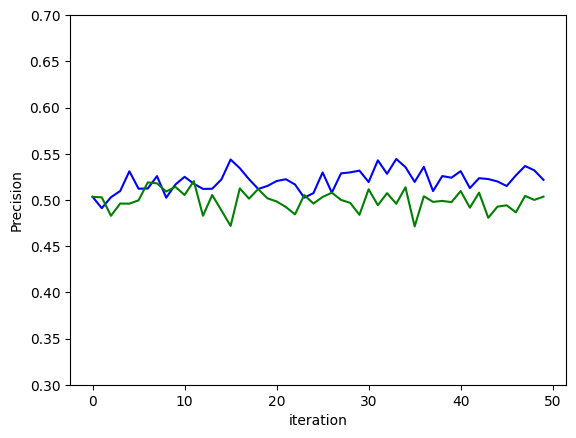

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(metrics_pdf['Precision@10'], color='b')
plt.plot(baseline_metrics_pdf['Precision@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('Precision')
plt.ylim(0.3, 0.7)
#plt.savefig('precision_mixed_sample.png', dpi=300) 

(0.0, 1.01)

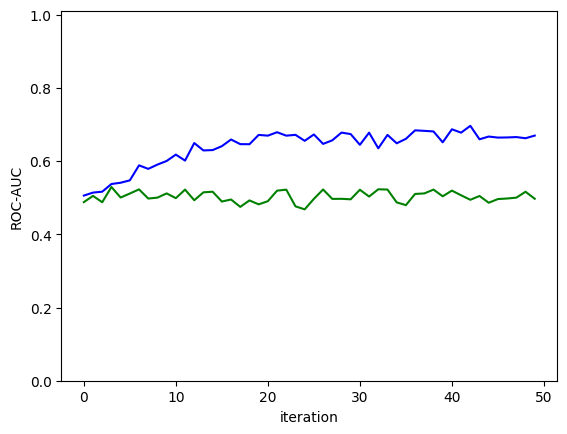

In [14]:
plt.plot(metrics_pdf['RocAuc@10'], color='b')
plt.plot(baseline_metrics_pdf['RocAuc@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('ROC-AUC')
plt.ylim(0.0, 1.01)